In [1]:
import functools
import itertools
import math
import re
import statistics
from functools import reduce
from pprint import pprint
from typing import (
    List,
    Optional,
    Generator,
    NamedTuple,
    Tuple,
    Set,
    Any,
    Dict,
    Union,
    Callable,
    Iterable,
    Sequence,
)

import rich.panel
import sklearn.base
from alive_progress import alive_bar
from numpy.distutils.misc_util import is_sequence
from tqdm import tqdm, trange
from log_symbols import LogSymbols

import overrides as overrides
import pandas as pds
import tabulate as tabulate
from collections import namedtuple
from sklearn import linear_model, metrics, preprocessing, model_selection, svm
from tabulate import tabulate
from pathlib import Path
import pickle
from halo import Halo
import random
import argparse
import sys
from sklearn.experimental import enable_halving_search_cv
from sklearn import neural_network, tree
from sklearn.model_selection import (
    HalvingGridSearchCV,
    RandomizedSearchCV,
    HalvingRandomSearchCV,
)
import scipy.stats as scistats

import rich.progress
import commons
from data_types import PickleOut
from rich.traceback import install as niceTracebacks
from rich.table import Table as rTable

from db_actions import db_actions
import numpy as np

from linRegPred import getSplits, getTransformers
from scipy.stats import rankdata
from sklearn.metrics import r2_score
import textdistance as TD

In [2]:
with db_actions.connect() as conn:
    dF = pds.read_sql('SELECT * FROM "runtimeScorePredBase1000"', conn)
# print(dF)
all_x_cols = [
    "build-linux-kernel1",
    "fio2",
    "fio3",
    "fio4",
    "fio5",
    "fio6",
    "fio7",
    "fio8",
    "fio9",
    "iperf10",
    "iperf11",
    "iperf12",
    "iperf13",
    "john-the-ripper14",
    "john-the-ripper15",
    "ramspeed16",
    "ramspeed17",
    "ramspeed18",
    "ramspeed19",
    "ramspeed20",
    "ramspeed21",
    "ramspeed22",
    "ramspeed23",
    "ramspeed24",
    "ramspeed25",
    "stream26",
    "stream27",
    "stream28",
    "stream29",
    "pCpu",
    "cpus",
    "rss",
    "vmem",
    "rchar",
    "wchar",
    "syscr",
    "syscw",
]
filtered_x_cols = ['john-the-ripper15', 'ramspeed17', 'ramspeed18', 'ramspeed19', 'ramspeed20', 'ramspeed21',
                   'ramspeed23', 'ramspeed24', 'ramspeed25', 'pCpu', 'cpus', 'vmem', 'rchar', 'wchar', 'syscr',
                   'syscw']
x_cols = filtered_x_cols
y_cols = "realtime"

X: pds.DataFrame = dF[x_cols]
y: pds.DataFrame = dF[y_cols]

## Deprecated

In [ ]:
t = rTable(title="results")
t.add_column("cv")
t.add_column("unknown")
t.add_column("cv score")
t.add_column("unknown score")
for split in getSplits(dF, 1, x_cols, y_cols, cvSize=1, unknownSize=1):
    X_train, y_train, X_test, y_test, X_unknown, y_unknown, X_trans, ukwfs, cvwfs = split
    model = tree.DecisionTreeRegressor()
    model.fit(X_train, y_train)
    # print(cvwfs, ukwfs, model.score(X_test, y_test), model.score(X_unknown, y_unknown))
    t.add_row(cvwfs[0], ukwfs[0], str(model.score(X_test, y_test)), str(model.score(X_unknown, y_unknown)))
rich.print(t)

In [ ]:
X_trans = getTransformers(X, 1)
scale1, poly, scale2 = X_trans
X_scaled = scale2.transform(poly.transform(scale1.transform(X)))
res2 = list()
for i in range(100):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.2)
    model = tree.DecisionTreeRegressor()
    model.fit(X_train, y_train)
    res2.append(model.score(X_test, y_test))

In [ ]:
rich.print(np.average(res2), np.std(res2))

## Current

In [3]:
taskNames = pds.unique(dF.taskName)


def pickCVTasks():
    cvTasks = list(taskNames)
    totalData = len(dF)
    while len(dF.query("taskName in @cvTasks")) > .3 * totalData:
        cvTasks = list()
        remainingTasks = list(taskNames)
        while len(dF.query("taskName in @cvTasks")) < .2 * totalData:
            pick = np.random.choice(remainingTasks)
            remainingTasks.remove(pick)
            cvTasks.append(pick)
    return cvTasks


nodeIds = pds.unique(dF.nodeConfig)


def pickCVNodes(p=0.8):
    cvNodes = list(nodeIds)
    totalData = len(dF)
    while len(dF.query("nodeConfig in @cvNodes")) > (p + 0.05) * totalData:
        cvNodes = list()
        remainingNodes = list(nodeIds)
        while len(dF.query("nodeConfig in @cvNodes")) < p * totalData:
            pick = np.random.choice(remainingNodes)
            remainingNodes.remove(pick)
            cvNodes.append(pick)
    return cvNodes

In [4]:
def listProd(l):
    return reduce(lambda a, x: a * x, l, 1)

In [ ]:
X_trans = getTransformers(X, 1)
scale1, poly, scale2 = X_trans
X_scaled = scale2.transform(poly.transform(scale1.transform(X)))
res2 = list()
done = set()
for i in range(100):
    cvNodes = pickCVNodes()
    #while listProd([i - 164 for i in cvNodes]) in done:
    #    cvNodes = pickCVNodes()
    #done.add(listProd([i - 164 for i in cvNodes]))
    train = dF.query("nodeConfig not in @cvNodes")
    X_train = train[x_cols]
    X_train = scale2.transform(poly.transform(scale1.transform(X_train)))
    y_train = train[y_cols]
    test = dF.query("nodeConfig in @cvNodes")
    X_test = test[x_cols]
    X_test = scale2.transform(poly.transform(scale1.transform(X_test)))
    y_test = test[y_cols]
    model = tree.DecisionTreeRegressor()
    #model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    res2.append((cvNodes, model.score(X_test, y_test)))

In [ ]:
t = rTable(title="results")
t.add_column("cv tasks")
t.add_column("score")
for r in res2[:5]:
    cv, s = r
    print(cv, s)
    #t.add_row(", ".join(list(cv)), str(s))
print("average:", np.average([s for cv, s in res2]), "std:", np.std([s for cv, s in res2]))
#rich.print(t)


In [ ]:
tmp = dict()
seen = dict()
for r in res2:
    cv, s = r
    for c in cv:
        if c not in tmp.keys():
            tmp[c] = 0
            seen[c] = 0
        tmp[c] = tmp[c] + s / len(cv)
        seen[c] = seen[c] + 1
for k in tmp.keys():
    tmp[k] = tmp[k] / seen[k]
t1 = tmp.keys()
t2 = tmp.values()
t = list(zip(t1, t2))
print(sorted(t, key=lambda x: x[1]))
print(np.average(list(t2)), np.std(list(t2)))

## Test n cv nodes

In [5]:

nodeIds = pds.unique(dF.nodeConfig)


def pickNCVNodes(n):
    return np.random.choice(nodeIds, size=n)

In [21]:
X_trans = getTransformers(X, 1)
scale1, poly, scale2 = X_trans
X_scaled = scale2.transform(poly.transform(scale1.transform(X)))
res2 = list()
done = set()
for n in range(1, len(nodeIds)):
    for i in range(min(100, len(nodeIds) ** n)):
        cvNodes = pickNCVNodes(n)
        #while listProd([i - 164 for i in cvNodes]) in done:
        #    cvNodes = pickCVNodes()
        #done.add(listProd([i - 164 for i in cvNodes]))
        train = dF.query("nodeConfig not in @cvNodes")
        X_train = train[x_cols]
        X_train = scale2.transform(poly.transform(scale1.transform(X_train)))
        y_train = train[y_cols]
        test = dF.query("nodeConfig in @cvNodes")
        X_test = test[x_cols]
        X_test = scale2.transform(poly.transform(scale1.transform(X_test)))
        y_test = test[y_cols]
        model = tree.DecisionTreeRegressor()
        #model = linear_model.LinearRegression()
        model.fit(X_train, y_train)
        res2.append((n, cvNodes, model.score(X_test, y_test)))
    print(n)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [22]:
tmp2 = dict()
for r in res2:
    n, cv, s = r
    if n not in tmp2.keys():
        tmp2[n] = list()
    tmp2[n].append(s)
tmp3 = list()
for k, v in tmp2.items():
    print(k, np.average(v), np.std(v))
    tmp3.append(np.average(v))

1 0.9422824324399939 0.0635154210478398
2 0.9038883208880296 0.15999753509400258
3 0.9165618957293935 0.10809344495395581
4 0.9369629665513862 0.05945455887149883
5 0.9278829619224822 0.05189776581392482
6 0.9274815223728216 0.06024652104463395
7 0.9098042142131371 0.06145476393157696
8 0.9084316726293423 0.05740553525821722
9 0.9235113031161655 0.042161218868951814
10 0.9144501758132271 0.04247316667768753
11 0.9165369368018891 0.03697146279589086
12 0.922114997121928 0.04008189205369908
13 0.9165816862882562 0.03837136437027706
14 0.9084820208350716 0.03955452640105757
15 0.9166723481115224 0.03424420399190998
16 0.9088668309460424 0.041444351394612264
17 0.9125489244331402 0.03584378065851313
18 0.9029451679895862 0.04025755265640996
19 0.9111702416951017 0.029859036802271057
20 0.9122200892230934 0.03094559785141516
21 0.9034645840828339 0.032287202602485486
22 0.9083088496846456 0.030928013839186603
23 0.9019667906746018 0.030037293649222797
24 0.9057629207760733 0.028189281246824

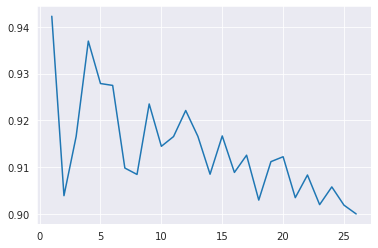

In [23]:
import seaborn as sns

p = sns.lineplot(x=range(1, len(nodeIds)), y=tmp3)

## Test rank accuracy

In [12]:
X_trans = getTransformers(X, 1)
scale1, poly, scale2 = X_trans
cvNodes = pickCVNodes(.5)
train = dF.query("nodeConfig not in @cvNodes")
X_train = train[x_cols]
X_train = scale2.transform(poly.transform(scale1.transform(X_train)))
y_train = train[y_cols]
test = dF.query("nodeConfig in @cvNodes")
X_test = test[x_cols]
X_test = scale2.transform(poly.transform(scale1.transform(X_test)))
y_test = test[y_cols]
model = tree.DecisionTreeRegressor()
#model = neural_network.MLPRegressor(max_iter=1000)
#model = linear_model.LinearRegression()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [45]:
print(y_test)

0         3517
2         6820
3         5462
7         9415
8         7030
         ...  
33226     6000
33227     1000
33228     4000
33229     4335
33230    17551
Name: realtime, Length: 17290, dtype: int64


In [46]:
qqqqq = pds.DataFrame({"real": y_test, "pred": model.predict(X_test)})

In [47]:
print(np.average(qqqqq.real - qqqqq.pred))

-1662.8058698801356


In [13]:
model.score(X_test, y_test)

0.8468154122752858

In [14]:
model.score(scale2.transform(poly.transform(scale1.transform(X))), y)

0.9348549563408436

In [50]:
ranks = dF["rank"]

In [141]:
model.predict(scale2.transform(poly.transform(scale1.transform(X))))

array([ 3517.,  5041.,  6820., ...,  6000.,  7143., 32821.])

In [6]:
tasks = pds.unique(dF["taskName"])
wfs = pds.unique(dF["wfName"])

In [15]:
with db_actions.connect() as conn:
    test_df = pds.read_sql('SELECT * FROM "averageRuntimeScorePredBase1000"', conn)
# print(test_df)
X_test_test: pds.DataFrame = test_df[x_cols]
y_test_test: pds.DataFrame = test_df[y_cols]

X_trans_test = getTransformers(X_test_test, 1)
scale1_test, poly_test, scale2_test = X_trans_test

In [16]:
t = model.predict(scale2_test.transform(poly_test.transform(scale1_test.transform(X_test_test))))
yo = test_df.assign(predTime=t)
yo = yo.sort_values(by=["wfName", "taskName", "nodeConfig"], ignore_index=True)
#print(yo)
#print(rankdata(np.array(yo.predTime).reshape((-1,27)), method="min", axis=1).reshape((-1)))
yo = yo.assign(predRank=rankdata(np.array(yo.predTime).reshape((-1, 27)), method="min", axis=1).reshape((-1)))
#print(yo)
comp1 = np.array(yo["rank"]).reshape((-1, 27))
comp2 = np.array(yo.predRank).reshape((-1, 27))
print(r2_score(comp1, comp2))

-8.397881951528738


In [17]:
def modelRankR2(model_):
    res = test_df.assign(
        predTime=model_.predict(scale2_test.transform(poly_test.transform(scale1_test.transform(X_test_test)))))
    res = res.sort_values(by=["wfName", "taskName", "nodeConfig"], ignore_index=True)
    res = res.assign(predRank=rankdata(np.array(res.predTime).reshape((-1, 27)), method="min", axis=1).reshape((-1)))
    comp1 = np.array(res["rank"]).reshape((-1, 27))
    comp2 = np.array(res.predRank).reshape((-1, 27))
    return r2_score(comp1, comp2)

In [18]:
def modelRankTD(model_):
    res = test_df.assign(
        predTime=model_.predict(scale2_test.transform(poly_test.transform(scale1_test.transform(X_test_test)))))
    res = res.sort_values(by=["wfName", "taskName", "nodeConfig"], ignore_index=True)
    res = res.assign(predRank=rankdata(np.array(res.predTime).reshape((-1, 27)), method="min", axis=1).reshape((-1)))
    comp1 = np.array(res["rank"]).reshape((-1, 27))
    comp2 = np.array(res.predRank).reshape((-1, 27))
    out = 0
    for c1, c2 in zip(comp1, comp2):
        out += TD.damerau_levenshtein("".join(map(lambda x: str(x), map(lambda x: chr(70 + x), list(c1)))),
                                      "".join(map(lambda x: str(x), map(lambda x: chr(70 + x), list(c1)))))
    if out == 0:
        return 1
    return len(comp1) / out  # reciprocal of average

In [19]:
from sklearn.metrics import classification_report

print(classification_report(yo["rank"], yo.predRank))

              precision    recall  f1-score   support

           1       0.06      0.23      0.10        81
           2       0.06      0.03      0.04        86
           3       0.06      0.04      0.05        89
           4       0.04      0.05      0.04        83
           5       0.02      0.01      0.01        76
           6       0.02      0.03      0.02        75
           7       0.06      0.09      0.07        79
           8       0.01      0.01      0.01        80
           9       0.05      0.05      0.05        74
          10       0.03      0.02      0.03        83
          11       0.02      0.03      0.02        76
          12       0.06      0.04      0.05        78
          13       0.10      0.05      0.07        77
          14       0.04      0.04      0.04        79
          15       0.03      0.02      0.03        84
          16       0.05      0.04      0.04        80
          17       0.02      0.03      0.02        72
          18       0.01    

In [51]:


res3 = pds.DataFrame(
    columns=["nodeid", "task", "wf", "realtime", "pred", "predrank", "rank", "angle", "dist", "metric"])
res4 = list()
res5 = list()
for t, w in test_df[["taskName", "wfName"]].values:
    dummy1 = [t]
    dummy2 = [w]
    q = test_df.query("taskName in @dummy1 and wfName in @dummy2")
    p = model.predict(scale2_test.transform(poly_test.transform(scale1_test.transform(q[x_cols]))))
    predranks = rankdata(p, method="min")
    qo = np.array(sorted(q[["nodeConfig", "rank"]].values, key=lambda x: x[1]))[:, 0]
    po = np.array(sorted(zip(q.nodeConfig, predranks), key=lambda x: x[1]))[:, 0]
    qo2 = np.array(sorted(q[["nodeConfig", "rank"]].values, key=lambda x: x[0]))[:, 1]
    po2 = np.array(sorted(zip(q.nodeConfig, predranks), key=lambda x: x[0]))[:, 1]
    res4.append(qo2)  #q["rank"])
    res5.append(po2)  #predranks)
    insert = pds.DataFrame(
        data={"nodeid": q.nodeConfig, "task": q.taskName, "wf": q.wfName, "realtime": q.realtime, "rank": q["rank"],
              "pred": p,
              "predrank": predranks, "angle": np.arccos((po.T @ qo) / (np.linalg.norm(qo) * np.linalg.norm(po))),
              "dist": np.linalg.norm(po - qo),
              "metric": np.linalg.norm((qo2 - po2))},
        columns=["nodeid", "task", "wf", "realtime", "pred", "predrank", "rank", "angle", "dist", "metric"])
    res3 = res3.append(insert, ignore_index=True)

In [52]:
res3

,nodeid,task,wf,realtime,pred,predrank,rank,angle,dist,metric
0,165,TRIMGALORE,nfcore/chipseq:1.2.2,15730.266667,43522.366427,12,16,0.059676,55.641711,22.090722
1,166,TRIMGALORE,nfcore/chipseq:1.2.2,15871.033333,45094.961765,16,17,0.059676,55.641711,22.090722
2,167,TRIMGALORE,nfcore/chipseq:1.2.2,15412.533333,43655.320287,14,13,0.059676,55.641711,22.090722
3,168,TRIMGALORE,nfcore/chipseq:1.2.2,19916.533333,47908.469912,22,22,0.059676,55.641711,22.090722
4,169,TRIMGALORE,nfcore/chipseq:1.2.2,20376.266667,49840.020853,26,25,0.059676,55.641711,22.090722
...,...,...,...,...,...,...,...,...,...,...
57586,189,ApplyBQSR,nfcore/sarek:2.7.1,6785.133333,11989.538850,26,27,0.061124,56.991227,25.019992
57587,190,ApplyBQSR,nfcore/sarek:2.7.1,6510.266667,11091.105425,24,24,0.061124,56.991227,25.019992
57588,191,ApplyBQSR,nfcore/sarek:2.7.1,3831.833333,8185.602529,19,10,0.061124,56.991227,25.019992
57589,192,ApplyBQSR,nfcore/sarek:2.7.1,3818.000000,4732.932958,4,9,0.061124,56.991227,25.019992


In [53]:
r2_score(res4, res5)

-3.1646062060245206

In [54]:
print(np.linalg.norm(res3["rank"] - res3["predrank"]))

1454.3287111241393


In [55]:
print(np.linalg.norm((res3["realtime"] - res3["pred"])))

5112145.15852196


In [56]:
print(np.average(res3.angle / 27))

0.002486583504144489


In [57]:
print(np.average(res3.dist / 27))

2.3183680085195046


In [58]:
print(np.average(res3.metric / 27))

1.1409400986021159


## New Plot

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
1 0.034165451147334415 0.0002568371531528394
2 0.033994462104881926 0.0004000561096740649
3 0.033947981738747815 0.0004048256455603902
4 0.03388119256886746 0.0004450862120826667
5 0.03379248119334985 0.0004702548227999618
6 0.03375192630340826 0.0004478500063126659
7 0.033713377041246176 0.0004960438990556096
8 0.033607703665076157 0.00041606821906320986
9 0.033661541357595116 0.0004332238832585778
10 0.03367198033630025 0.00044211557185852297
11 0.033630152202619154 0.00047454698564774285
12 0.03344631782755587 0.0004378870017457758
13 0.033486117025568654 0.0005322109850683672
14 0.03350150310384212 0.0005192387578219008
15 0.03340305606807918 0.000489964334716458
16 0.03333677295898145 0.0004968794317576911
17 0.03332680508423916 0.0005321202574918548
18 0.033406776978217166 0.0005742649728079925
19 0.03325894328540277 0.0005204630517221757
20 0.033322461109852194 0.0004779358120694197
21 0.033279374460377736 0.00

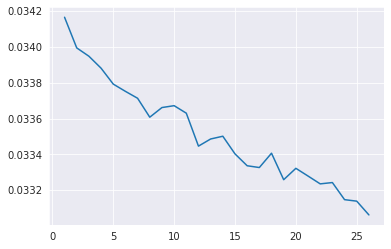

In [77]:
res10 = list()
for n in range(1, len(nodeIds)):
    for i in range(min(100, len(nodeIds) ** n)):
        cvNodes = pickNCVNodes(n)
        #while listProd([i - 164 for i in cvNodes]) in done:
        #    cvNodes = pickCVNodes()
        #done.add(listProd([i - 164 for i in cvNodes]))
        train = dF.query("nodeConfig not in @cvNodes")
        X_train = train[x_cols]
        X_train = scale2.transform(poly.transform(scale1.transform(X_train)))
        y_train = train[y_cols]
        test = dF.query("nodeConfig in @cvNodes")
        X_test = test[x_cols]
        X_test = scale2.transform(poly.transform(scale1.transform(X_test)))
        y_test = test[y_cols]
        model = tree.DecisionTreeRegressor()
        #model = linear_model.LinearRegression()
        model.fit(X_train, y_train)
        res10.append((n, cvNodes, modelRankTD(model)))
    print(n)
tmp10 = dict()
for r in res10:
    n, cv, s = r
    if n not in tmp10.keys():
        tmp10[n] = list()
    tmp10[n].append(s)
tmp11 = list()
for k, v in tmp10.items():
    print(k, np.average(v), np.std(v))
    tmp11.append(np.average(v))
import seaborn as sns

p = sns.lineplot(x=range(1, len(nodeIds)), y=tmp11)

## Export

In [20]:
best = None
for i in range(1000):
    cvNodes = pickCVNodes()
    train = dF.query("nodeConfig not in @cvNodes")
    X_train = train[x_cols]
    X_train = scale2.transform(poly.transform(scale1.transform(X_train)))
    y_train = train[y_cols]
    test = dF.query("nodeConfig in @cvNodes")
    X_test = test[x_cols]
    X_test = scale2.transform(poly.transform(scale1.transform(X_test)))
    y_test = test[y_cols]
    model = tree.DecisionTreeRegressor()
    #model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    if best is None:
        s = modelRankTD(model)
        best = (model, s)
        if s == 1:
            break
    elif (s := modelRankTD(model)) < best[1]:
        best = (model, s)
        if s == 1:
            break
    if i % 100 == 0:
        print(i)


0
100
200
300
400
500
600
700
800
900


In [26]:
print(best)

(DecisionTreeRegressor(), 1)


In [21]:
allInstances = list(range(165, 194))
allInstances.remove(174)
allInstances.remove(177)

In [22]:
from my_yaml import yaml_load

with open("nodeConfigIdLookup.yaml", "r") as f:
    t = yaml_load(f)
    nodeIDLUT = {v: k for k, v in t.items()}
predBase = test_df.assign(nodeName=test_df["nodeConfig"].transform(lambda x: nodeIDLUT[x]))

In [23]:
t = best[0].predict(scale2.transform(poly.transform(scale1.transform(predBase[x_cols]))))
predBase = predBase.assign(predTime=t)
predBase = predBase.sort_values(by=["wfName", "taskName", "nodeConfig"], ignore_index=True)
predBase = predBase.assign(
    predRank=rankdata(np.array(yo.predTime).reshape((-1, 27)), method="min", axis=1).reshape((-1)))

In [24]:
export = pds.DataFrame(data={"wfName": predBase.wfName, "taskName": predBase.taskName, "nodeName": predBase.nodeName,
                             "rank": predBase.predRank})

In [25]:
export.to_csv("DTR_TD_Rank_Export.csv", index=False)